<a href="https://colab.research.google.com/github/devonwallerson/covidWastewater/blob/main/covid_in_wastewater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


data = pd.read_csv('/content/drive/My Drive/SARS-CoV-2_concentrations_measured_in_NYC_Wastewater_20240314.csv')

data.head() # To display the first few rows of the dataset to get a better idea of what  preprocessing needs to take place.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Sample Date,Test date,WRRF Name,WRRF Abbreviation,Concentration SARS-CoV-2 gene target (N1 Copies/L),Per capita SARS-CoV-2 load (N1 copies per day per population),Annotation,"Population Served, estimated",Technology
0,08/31/2020,09/01/2020,26th Ward,26W,389.0,264000.0,Concentration below Method Limit of Quantifica...,290608,RT-qPCR
1,08/31/2020,09/01/2020,Bowery Bay,BB,1204.0,444000.0,NaN,924695,RT-qPCR
2,08/31/2020,09/01/2020,Coney Island,CI,304.0,169000.0,Concentration below Method Limit of Quantifica...,682342,RT-qPCR
3,08/31/2020,09/01/2020,Hunts Point,HP,940.0,574000.0,NaN,755948,RT-qPCR
4,08/31/2020,09/01/2020,Jamaica Bay,JA,632.0,233000.0,NaN,748737,RT-qPCR


In [ ]:
# Now we can clean and preprocess the data. To ensure accuracy, we will handle missing values,
# fix data types for date and time, and check for outliers.


missing_vals = data.isnull().sum() # This code tells us how many null values are in the dataset.

data['Sample Date'] = pd.to_datetime(data['Sample Date'], format = '%m/%d/%Y')
data['Test date'] = pd.to_datetime(data['Test date'], format = '%m/%d/%Y')
# Normalizing the data by converting the times to datetime format

print(missing_vals) #Gives us a better understanding of where our null values are.
print('\n')
print(data.dtypes) # Confirms that format is datetime.

# After this analysis, we understand that we have a lot of empty annotation lines.
# We can also drop the tests without a test date to ensure accuracy.


Sample Date                                                         0
Test date                                                          15
WRRF Name                                                           0
WRRF Abbreviation                                                   0
Concentration SARS-CoV-2 gene target (N1 Copies/L)                154
Per capita SARS-CoV-2 load (N1 copies per day per population)     193
Annotation                                                       3693
Population Served, estimated                                        0
Technology                                                          0
dtype: int64


Sample Date                                                      datetime64[ns]
Test date                                                        datetime64[ns]
WRRF Name                                                                object
WRRF Abbreviation                                                        object
Concentration SARS-CoV-2 gene targe

In [78]:
data.columns = data.columns.str.replace(' ', '_', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.replace('-', '_', regex=False)
data = data.dropna(subset=['Test_date']) # Dropping rows where there is no test date


for column in ['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_', 'Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population']:
    median_value = data[column].median()
    data.loc[data[column].isnull(), column] = median_value

# We used medians here because they are less sensitive to outliers, and is less likely to be skewed than the mean.

f_missing = data.isnull().sum()
print (f_missing)
print('\n')

# After this preprocessing step, missing test dates were dropped, and missing values
# in Concatenation, and Annotation column was dropped. We also used median values where
# per capita was empty.


Sample_Date                                                       0
Test_date                                                         0
WRRF_Name                                                         0
WRRF_Abbreviation                                                 0
Concentration_SARS_CoV_2_gene_target_N1_Copies/L_                 0
Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population       0
Annotation                                                     3693
Population_Served,_estimated_                                     0
Technology                                                        0
dtype: int64




In [83]:
# As an effort to handle outliers, we will focus on values within our interquartile range.

Q1 = data.quantile(0.25 , numeric_only = True)
Q3 = data.quantile(0.75, numeric_only = True) # This allows this calculation to occur only where the value is numeric

IQR = Q3 - Q1 # Calculation for the interquartile range
numeric_data = data.select_dtypes(include=['number'])


outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data) > (Q3 + 1.5 * IQR)).any(axis=1)

print(outliers)

cleanData = data[~outliers] # This is the dataset without the outlier values

data.shape, ' ', cleanData.shape

# This means that all our data fits within the IQR, which means it there are no outliers. We are good to proceed to data visualization.




0       False
1       False
2       False
3       False
4       False
        ...  
4643    False
4644    False
4645    False
4646    False
4647    False
Length: 4633, dtype: bool


((4633, 9), ' ', (4633, 9))

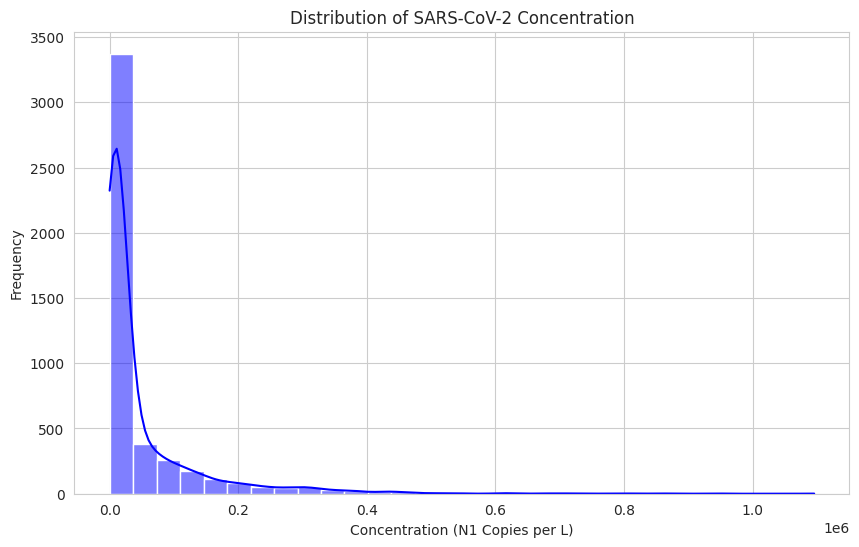

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's establish styling guidelines for our data visualizations.
sns.set_style ("whitegrid")

# Our first visualization will be a histogram. This gives us a good idea of the distribution of
# the target concentrations throughout the dataset

plt.figure(figsize = (10,6))
sns.histplot(cleanData['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'], kde=True, bins=30, color='blue')
plt.title('Distribution of SARS-CoV-2 Concentration')
plt.xlabel('Concentration (N1 Copies per L)')
plt.ylabel('Frequency')
plt.show()
# From this graph, we see that the data is skewed to the left. There are many more locations with lower concentration than higher concentration



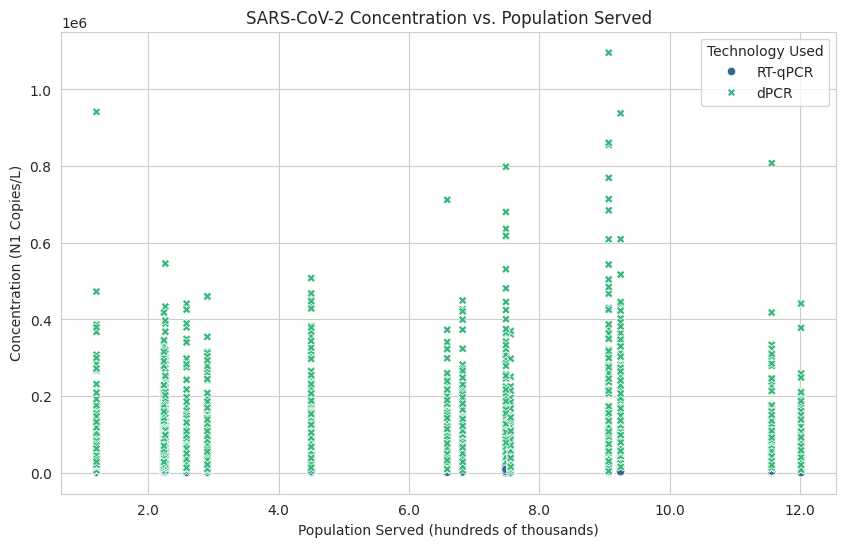

In [85]:
from matplotlib.ticker import FuncFormatter

# Next, let's use a scatter plot to see if the concentration has anything to do with the population that is being served.

# Custom formatter function to divide the population values by 100,000
def hundreds_of_thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1f' % (x * 1e-5)

formatter = FuncFormatter(hundreds_of_thousands)

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    x='Population_Served,_estimated_',
    y='Concentration_SARS_CoV_2_gene_target_N1_Copies/L_',
    data=cleanData,
    hue='Technology',
    style='Technology',
    palette='viridis'
)

plt.title('SARS-CoV-2 Concentration vs. Population Served')
plt.xlabel('Population Served (hundreds of thousands)')
plt.ylabel('Concentration (N1 Copies/L)')
plt.legend(title='Technology Used')

# Set the custom formatter for the x-axis
ax.xaxis.set_major_formatter(formatter)

# Redraw the plot with formatted x-axis
plt.draw()
plt.show()


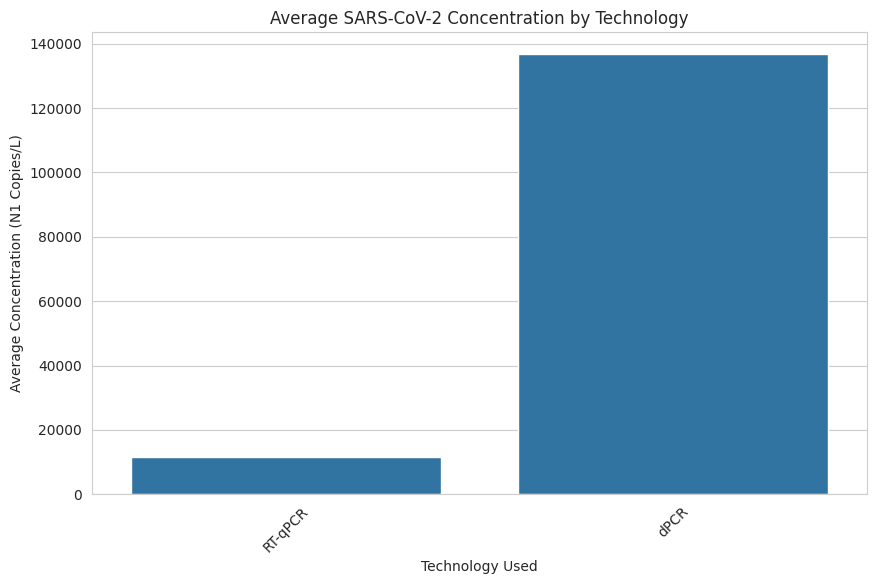

Sample_Date                                                    datetime64[ns]
Test_date                                                      datetime64[ns]
WRRF_Name                                                              object
WRRF_Abbreviation                                                      object
Concentration_SARS_CoV_2_gene_target_N1_Copies/L_                     float64
Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population           float64
Annotation                                                             object
Population_Served,_estimated_                                           int64
Technology                                                             object
dtype: object


In [86]:
# Secondly, let's use a bar plot to compare the two technologies being used to see if there is a major difference between the two

mean_by_tech = cleanData.groupby('Technology')['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Technology', y='Concentration_SARS_CoV_2_gene_target_N1_Copies/L_', data= mean_by_tech)
plt.title('Average SARS-CoV-2 Concentration by Technology')
plt.xlabel('Technology Used')
plt.ylabel('Average Concentration (N1 Copies/L)')
plt.xticks(rotation=45)
plt.show()

print(cleanData.dtypes) # Confirms that format is datetime.


# This shows when RT is used as compared to dP, there are much lower levels of COVID found. This could be due to the increased accuracy of RT which allows it to detect lesser amounts of covid

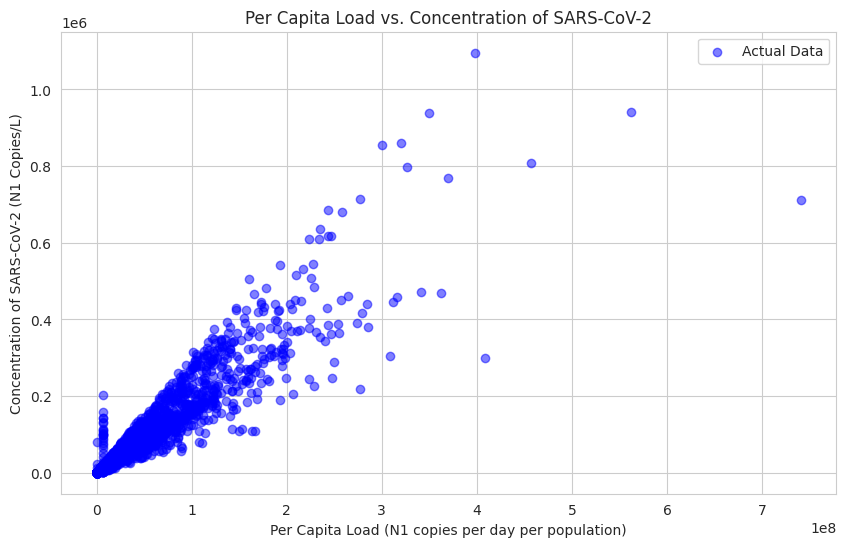

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = cleanData[['Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population']].values
y = cleanData['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'].values


# Create a scatter plot of the test data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Actual Data')

plt.title('Per Capita Load vs. Concentration of SARS-CoV-2')
plt.xlabel('Per Capita Load (N1 copies per day per population)')
plt.ylabel('Concentration of SARS-CoV-2 (N1 Copies/L)')
plt.legend()
plt.show()

# This scatterplot between the capita load and the concentration of COVID shows a linear relationship, we can gain more insight on this through the linear regression line.

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'Technology' categorical variable
encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False to get a dense array
technology_encoded = encoder.fit_transform(cleanData[['Technology']])
technology_encoded_df = pd.DataFrame(technology_encoded, columns=encoder.get_feature_names_out(['Technology']))

features_df = pd.concat([technology_encoded_df, cleanData[['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_']].reset_index(drop=True)], axis=1)

# Define the target variable
y = cleanData['Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, y, test_size=0.2, random_state=1)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Interpretation of the model outcome
print("Model coefficients:", model.coef_)
print("Model intercept:", model.intercept_)

# Now I have a trained model that considers both 'Technology' and 'Concentration_SARS_CoV_2_gene_target_N1_Copies/L_' to predict 'Per Capita'


R^2 score: 0.8275559183082359
Mean Squared Error: 467955314046326.8
Model coefficients: [-3.96541964e+06  3.96541964e+06  4.51312725e+02]
Model intercept: 4402915.308717933


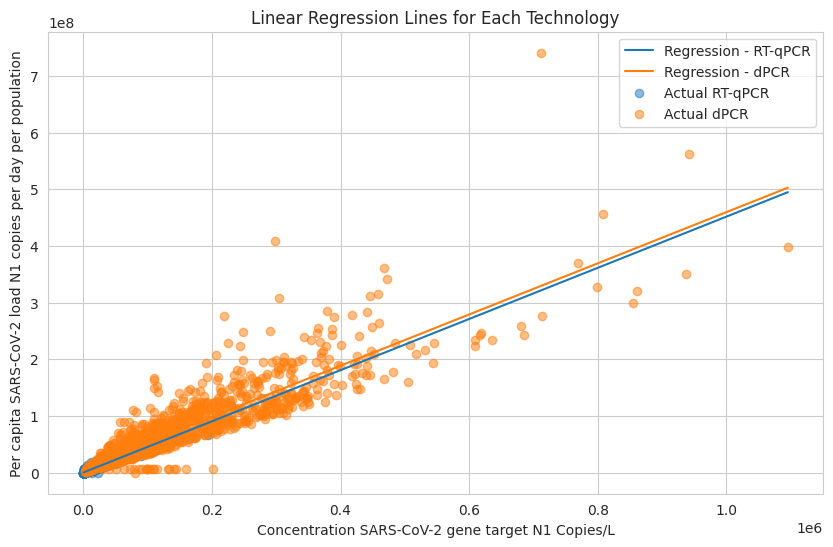

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a range of 'Concentration_SARS_CoV_2_gene_target_N1_Copies/L_' values for prediction
concentration_range = np.linspace(cleanData['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'].min(), cleanData['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'].max(), 100)

# Plot settings
plt.figure(figsize=(10, 6))

technology_categories = encoder.categories_[0]
for category in technology_categories:
    # Generate a DataFrame with the current category repeated for the length of the concentration range
    category_df = pd.DataFrame({ 'Technology': [category] * len(concentration_range) })

    # Encode this category
    category_encoded = encoder.transform(category_df)

    # Create a DataFrame for the encoded data plus the concentration range
    prediction_input = np.hstack([category_encoded, concentration_range.reshape(-1, 1)])

    # Ensure the columns match the training data
    prediction_input_df = pd.DataFrame(prediction_input, columns=features_df.columns)

    # Predict using the model
    predictions = model.predict(prediction_input_df)

    # Plot the regression line
    plt.plot(concentration_range, predictions, label=f'Regression - {category}')

# Plot actual data for comparison
for category in technology_categories:
    subset = cleanData[cleanData['Technology'] == category]
    plt.scatter(subset['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'], subset['Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population'], alpha=0.5, label=f'Actual {category}')

plt.xlabel('Concentration SARS-CoV-2 gene target N1 Copies/L')
plt.ylabel('Per capita SARS-CoV-2 load N1 copies per day per population')
plt.title('Linear Regression Lines for Each Technology')
plt.legend()
plt.show()


Coefficient (Per Capita Load): 0.0018262413776215626
Intercept: 3207.5088421725377
Mean Squared Error (MSE): 1040168221.776128
R-squared: 0.8806126865104098


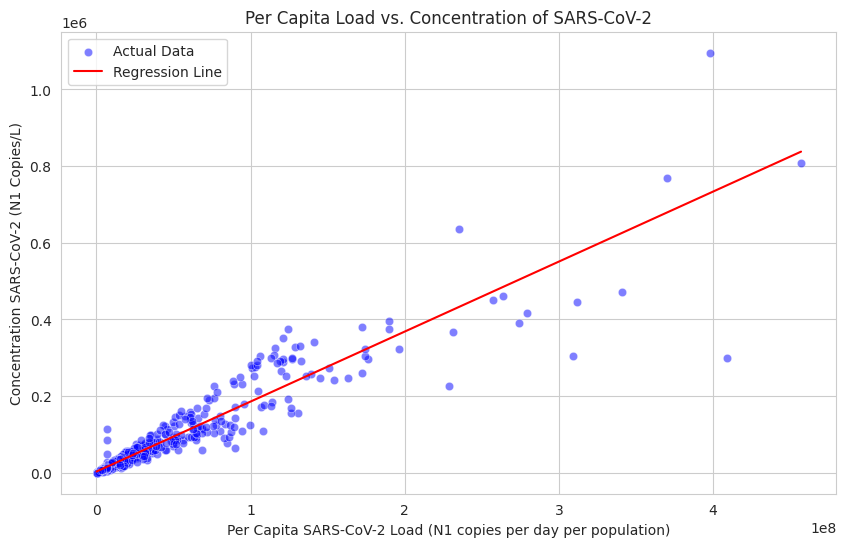

In [88]:
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Isolate the features (X) and the target variable (y)
X = cleanData[['Per_capita_SARS_CoV_2_load_N1_copies_per_day_per_population']].values  # Adjust column name as necessary
y = cleanData['Concentration_SARS_CoV_2_gene_target_N1_Copies/L_'].values  # Adjust column name as necessary

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the model
y_pred = model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the coefficients
print(f'Coefficient (Per Capita Load): {model.coef_[0]}')
print(f'Intercept: {model.intercept_}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

# Plotting the scatter plot and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test.flatten(), y=y_test, color='blue', alpha=0.5, label='Actual Data')

# Calculate the regression line
line_x = np.linspace(X_test.min(), X_test.max(), 100)
line_y = model.predict(line_x.reshape(-1, 1))

sns.lineplot(x=line_x.flatten(), y=line_y, color='red', label='Regression Line')

plt.xlabel('Per Capita SARS-CoV-2 Load (N1 copies per day per population)')
plt.ylabel('Concentration SARS-CoV-2 (N1 Copies/L)')
plt.title('Per Capita Load vs. Concentration of SARS-CoV-2')
plt.legend()
plt.show()

# Interpreting these values shows us that this linear regression line accounts for 88% of the values, showing a strong linear relationship between the two columns.
# The magnitute of the coefficient is small, but it mantains its linearity.
# The intercept is 3207, meaning in a hypothetical situation an area with no cases would have 3207 copies in the water system

